# Linear Regression Model #

The theory is that increased pupil area in the test subject indicates increased neural activity. If this is correct then it should be possible to use linear regression to model the spike counts.

In [1]:
using CSV
using DataFrames
using Turing
using MCMCChains
using Plots
using StatsPlots
using StatsBase
using Distributions
using NPZ
using Statistics

## Importing ##

In [2]:
data_path = "spikeAndBehavioralData/allData/Cori_2016-12-14/"
eye_area = npzread("$(data_path)eye.area.npy")
clusterids = npzread("$(data_path)spikes.clusters.npy")[:] 
spiketimes = npzread("$(data_path)spikes.times.npy")[:]
eyetimes = npzread("$(data_path)eye.timestamps.npy")[:,2]

267759-element Vector{Float64}:
   15.982835732952108
   15.992836839228154
   16.0028379455042
   16.012839051780247
   16.022840158056297
   16.03284126433234
   16.042842370608387
   16.052843476884433
   16.06284458316048
   16.072845689436527
   16.082846795712577
   16.092847901988623
   16.10284900826467
    ⋮
 2693.748894411977
 2693.7588955182528
 2693.768896624529
 2693.778897730805
 2693.7888988370814
 2693.7988999433574
 2693.8089010496333
 2693.8189021559097
 2693.828903262185
 2693.8389043684615
 2693.8489054747374
 2693.8589065810133

## Pre-Processing ##

The first step is to process the data for when each cluster spikes into an array. Each row should represent a cluster and each column should represent a time bin. Each entry to the array is the amount of times that that particular neuron spiked over the period of the time bin (e.g. 1 second).

In [3]:
# count spikes for each cluster
unique_clusterids = sort(unique(clusterids))
nclusters = length(unique_clusterids) # number of clusters
binedges = -0.5 .+ append!(unique_clusterids,clusterids[end]+1)
h_spikecounts = StatsBase.fit(Histogram,clusterids[:],binedges)
spikecounts = h_spikecounts.weights
spikerates = spikecounts./maximum(spiketimes)

# get spike counts per timebin
dt = 1 # seconds
maxtime = maximum(spiketimes)
timebin_edges = (20:dt:maxtime-20)
nt = length(timebin_edges)
spikecount_array = Array{Int64}(undef,nclusters,nt-1)

for i = 1:nclusters
    inds = findall(clusterids.==i)
    htemp = StatsBase.fit(Histogram,spiketimes[:][inds],timebin_edges)
    spikecount_array[i,:] = htemp.weights
end

The second step is to reformat the eye area data to rescale the time frame. This is necessary as the eye area data was captured using a camera the cluster spiketimes was captured using a neuropixel probe, meaning that although they record for the same time period, the time scales are incorrect. 

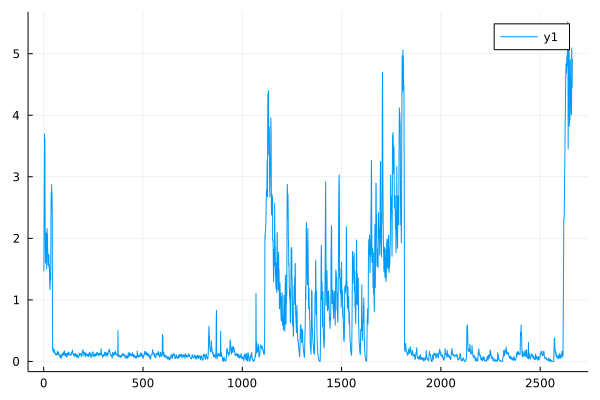

In [4]:
# Remove all negative areas from the eye_area data
for i in 1:length(eye_area)
    if eye_area[i] < 0
        eye_area[i] = 0
    end
end

# Define the bounderies for the timebins for eye areas
dt = 1 # seconds
maxtime = maximum(spiketimes)
timebin_edges = (20:dt:maxtime-20)
nt = length(timebin_edges)
eye_area_bin = zeros(Float32, nt-1)

# Generate the average eye area for each time bin.
j = 1
for i in 1:nt-1
    count = 0
    while eyetimes[j] <= timebin_edges[i+1]
        if eyetimes[j] >= timebin_edges[i]
            eye_area_bin[i] += eye_area[j]
            count += 1
        end
        j += 1
    end
    eye_area_bin[i] /= count
end

plot(eye_area_bin)


We are now left with eye area averages which correspond to the same time period as each spikecount for each neuron. 

The number of clusters is 1085
Number of spikecount timebins is 2662
Number of eye area averages is 2662
There is a Pearson correlation coefficient of 0.2059455 between the two data


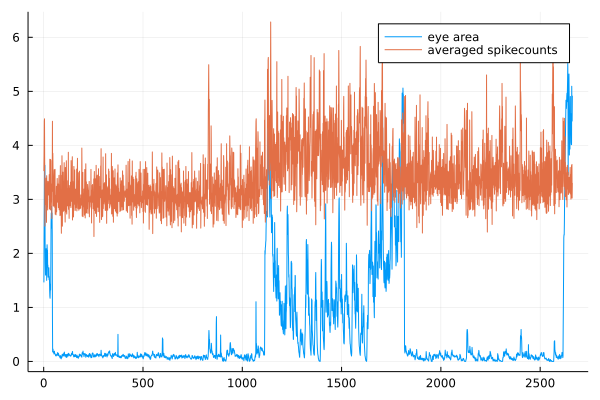

In [5]:
println("The number of clusters is $(length(spikecount_array[:,1]))")
println("Number of spikecount timebins is $(length(spikecount_array[1,:]))")
println("Number of eye area averages is $(length(eye_area_bin))")

summed_spikecounts = zeros(Float32, length(spikecount_array[1,:]))
for cluster in 1:length(spikecount_array[:,1])
    summed_spikecounts += spikecount_array[cluster,:]
end

average_spikecounts = summed_spikecounts ./ length(spikecount_array[:,1])

println("There is a Pearson correlation coefficient of ", cor(average_spikecounts, eye_area_bin), " between the two data")

plot(eye_area_bin, label="eye area")
plot!(average_spikecounts, label="averaged spikecounts")

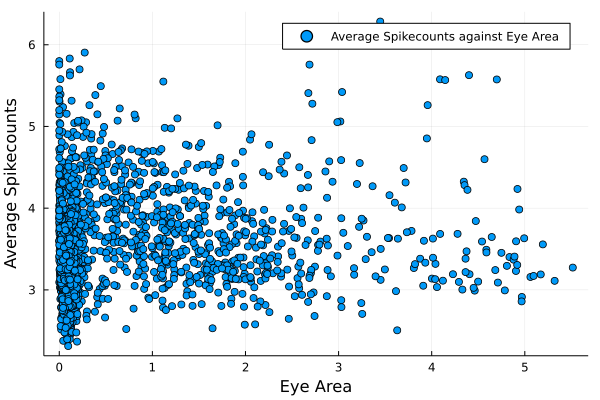

In [6]:
scatter(eye_area_bin, average_spikecounts, label="Average Spikecounts against Eye Area")
xlabel!("Eye Area")
ylabel!("Average Spikecounts")

## Modeling ##

### Linear Regression Model ###

We can fit a regression line for the average spikecounts.

$$average\_{sc}_i \sim Normal(\mu_i, \sigma)$$

where $i$ is the index of a time bin. The mean of the Normal distribution can be modelled by a linear function.

$$\mu_i = a + b*eye\_ area_i$$

$a$, $b$ and $\sigma$ are priors modelled by

$$a \sim Gamma(2, 2)$$ 
$$b \sim Normal(0, 1)$$ 
$$\sigma \sim Gamma(2, 2)$$

In [7]:
@model function linear_regression(eye_area_bin, average_spikecounts)
    # Priors
    a ~ Gamma(2, 2)
    b ~ Normal(0, 1)
    sigma ~ Gamma(2, 2)

    mu = a .+ b * eye_area_bin

    return average_spikecounts ~ MvNormal(mu, sigma)
end

linear_regression (generic function with 2 methods)

In [8]:
md = linear_regression(eye_area_bin, average_spikecounts)
chain = sample(md, NUTS(0.65), MCMCThreads(), 1000, 4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/alex/.julia/packages/AbstractMCMC/fnRmh/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/alex/.julia/packages/Turing/JdESU/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/alex/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/alex/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /home/alex/.julia/packages/Turing/JdESU/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/alex/.julia/packages/Turing/JdESU/src/inference/hmc.jl:1

Chains MCMC chain (1000×15×4 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 27.48 seconds
Compute duration  = 24.26 seconds
parameters        = a, b, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           a    3.3518    0.0122     0.0002    0.0002   3669.3758    1.0008    ⋯
           b    0.1216    0.0112     0.0002    0.0002   2599.9492    1.0003    ⋯
       sigma    0.5503    0.0077     0.0001    0.0001   3076.7462    0.9998    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.

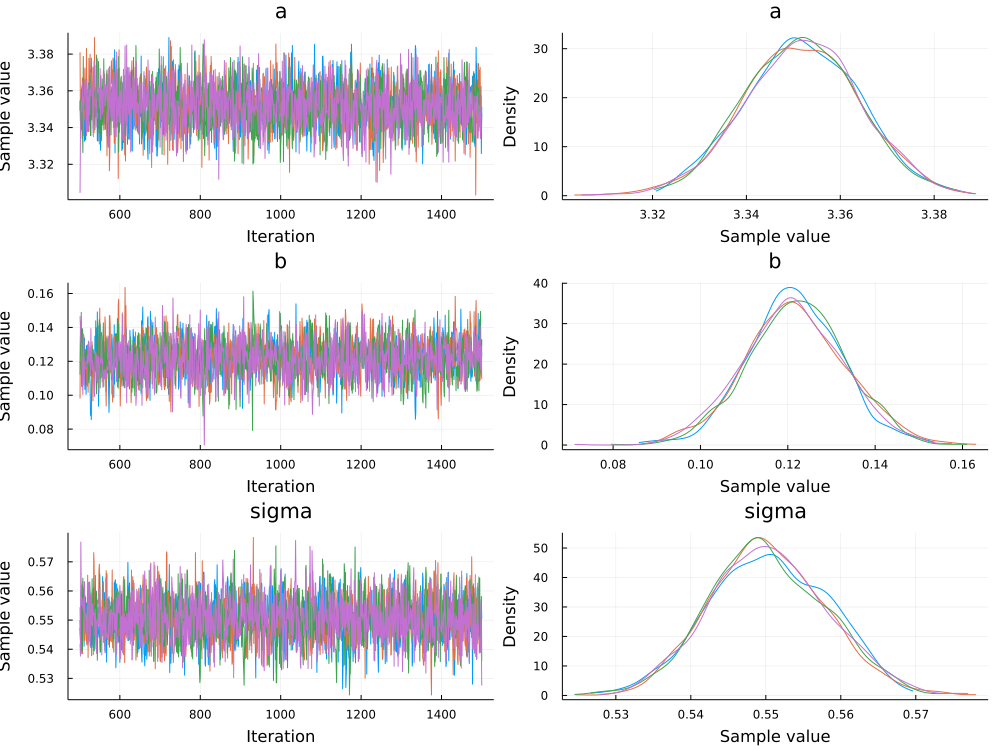

In [14]:
plt = plot(chain)

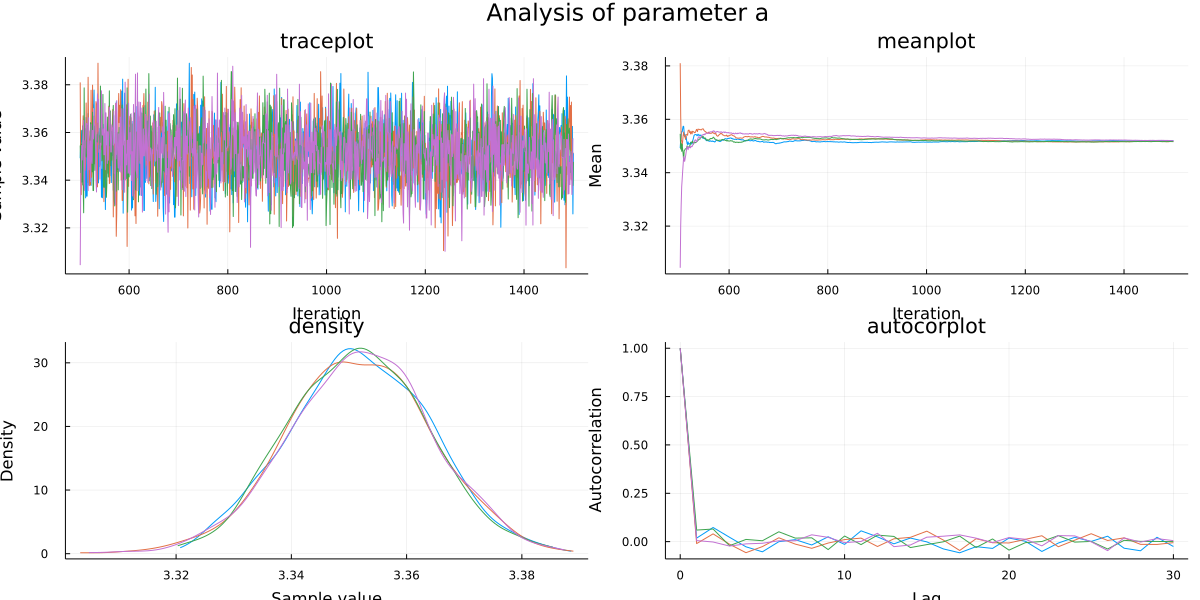

In [10]:
plot(
	traceplot(group(chain, :a), title="traceplot"),
	meanplot(group(chain, :a), title="meanplot"),
	density(group(chain, :a), title="density"),
	autocorplot(group(chain, :a), title="autocorplot"),
	size=(1200, 600),
    plot_title = "Analysis of parameter a"
)

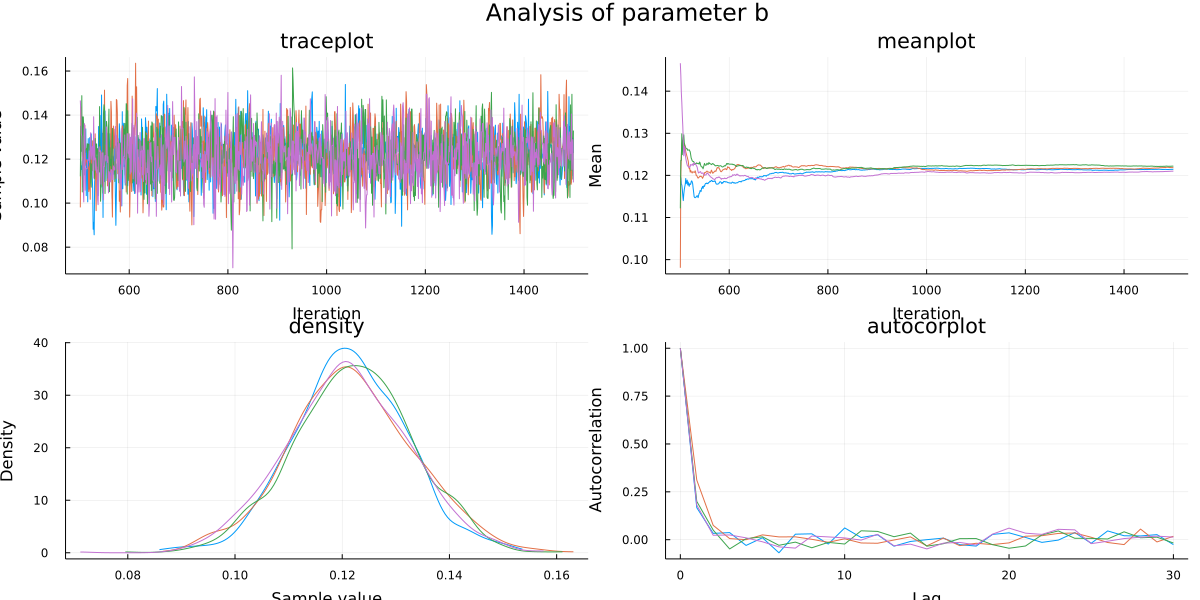

In [11]:
plot(
	traceplot(group(chain, :b), title="traceplot"),
	meanplot(group(chain, :b), title="meanplot"),
	density(group(chain, :b), title="density"),
	autocorplot(group(chain, :b), title="autocorplot"),
	size=(1200, 600),
    plot_title = "Analysis of parameter b"
)

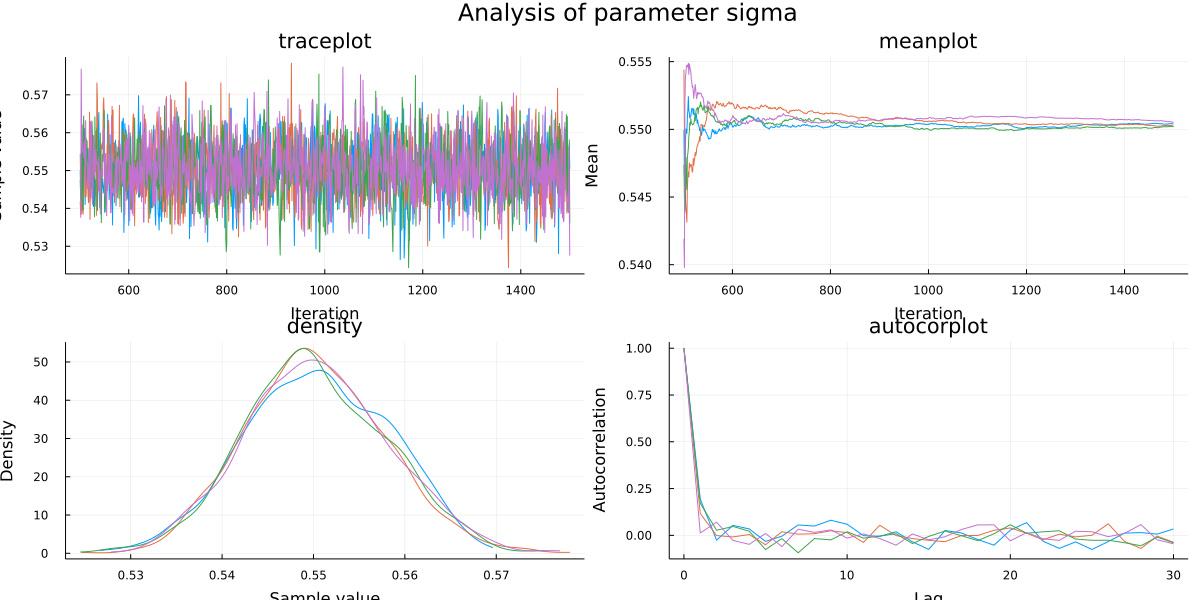

In [12]:
plot(
	traceplot(group(chain, :sigma), title="traceplot"),
	meanplot(group(chain, :sigma), title="meanplot"),
	density(group(chain, :sigma), title="density"),
	autocorplot(group(chain, :sigma), title="autocorplot"),
	size=(1200, 600),
    plot_title = "Analysis of parameter sigma"
)